In [1]:
!nvidia-smi

Tue Jul 21 15:53:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#pip install detectron2==0.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [5]:
#pip install pyyaml --upgrade

In [7]:
#!wget -nc https://lilablobssc.blob.core.windows.net/conservationdrones/TrainReal.zip

In [9]:
#!unzip -n TrainReal.zip

In [11]:
#import os

#os.makedirs("./output")

In [12]:
import csv
import glob
import matplotlib.pyplot
import pandas
import detectron2.structures
import detectron2.config
import detectron2.model_zoo
import detectron2.engine


def getdictionarieslist():

  dictionarieslist = []

  for folderpath in sorted(glob.glob("/content/TrainReal/images/??????????_??????????")):

    print(folderpath)

    frontlength = len("/content/TrainReal/images/")

    endpart = folderpath[frontlength:frontlength+21]

    #print(endpart)

    annotationpath = "/content/TrainReal/annotations/" + endpart + ".csv"

    dataframe = pandas.read_csv(annotationpath, header=None)

    #print(dataframe)

    #print(annotationpath)

    for imagepath in sorted(glob.glob(folderpath + "/*")):

      dictionary = {}

      dictionary["file_name"] = imagepath

      #print(dictionary)

      numpyarray = matplotlib.pyplot.imread(imagepath)

      #print(numpyarray)

      #print(numpyarray.shape)

      dictionary["height"] = int(numpyarray.shape[0])

      dictionary["width"] = int(numpyarray.shape[1])

      #print(dictionary)

      dictionary["image_id"] = imagepath[frontlength+21+1:frontlength+21+1+32]

      #print(dictionary)

      num = int(imagepath[frontlength+21+1+22:frontlength+21+1+32])

      #print(num)

      booleanarray = dataframe.loc[:, 0] == num

      #print(booleanarray)

      rowsarray = dataframe.loc[booleanarray, :].to_numpy()

      #print(rowsarray)

      rowdictionarieslist = []

      for rowarray in rowsarray:

        #print(rowarray)

        #print(rowarray[7])

        rowdictionary = {}

        if rowarray[7] == -1:

          rowdictionary["category_id"] = 9
        
        else:

          rowdictionary["category_id"] = int(rowarray[7])

        rowdictionary["bbox"] = [float(rowarray[2]), float(rowarray[3]), float(rowarray[4]), float(rowarray[5])]

        #print(rowdictionary)

        rowdictionary["bbox_mode"] = detectron2.structures.BoxMode.XYWH_ABS

        #print(rowdictionary)

        rowdictionarieslist.append(rowdictionary)

        #print(rowdictionarieslist)
      
      dictionary["annotations"] = rowdictionarieslist

      dictionarieslist.append(dictionary)

    #print(dictionarieslist)

  #print(dictionarieslist)

  return dictionarieslist

In [13]:
dictionarieslist = getdictionarieslist()

/content/TrainReal/images/0000000010_0000000000
/content/TrainReal/images/0000000054_0000000000
/content/TrainReal/images/0000000056_0000000000
/content/TrainReal/images/0000000062_0000000000
/content/TrainReal/images/0000000067_0000000005
/content/TrainReal/images/0000000067_0000000012
/content/TrainReal/images/0000000067_0000000014
/content/TrainReal/images/0000000067_0000000015
/content/TrainReal/images/0000000067_0000000019
/content/TrainReal/images/0000000067_0000000024
/content/TrainReal/images/0000000067_0000000025
/content/TrainReal/images/0000000067_0000000026
/content/TrainReal/images/0000000067_0000000027
/content/TrainReal/images/0000000067_0000000028
/content/TrainReal/images/0000000067_0000000029
/content/TrainReal/images/0000000067_0000000031
/content/TrainReal/images/0000000067_0000000032
/content/TrainReal/images/0000000067_0000000040
/content/TrainReal/images/0000000067_0000000041
/content/TrainReal/images/0000000067_0000000045
/content/TrainReal/images/0000000067_000

In [14]:
import random

random.seed(177)

tempdictionarieslist = dictionarieslist[:]

random.shuffle(tempdictionarieslist)

traindictionarieslist = tempdictionarieslist[:-1000]

testdictionarieslist = tempdictionarieslist[-1000:]

In [15]:
print(traindictionarieslist[1])

print(testdictionarieslist[100])

{'file_name': '/content/TrainReal/images/0000000364_0000000000/0000000364_0000000000_0000006132.jpg', 'height': 321, 'width': 700, 'image_id': '0000000364_0000000000_0000006132', 'annotations': []}
{'file_name': '/content/TrainReal/images/0000000067_0000000012/0000000067_0000000012_0000000885.jpg', 'height': 512, 'width': 640, 'image_id': '0000000067_0000000012_0000000885', 'annotations': []}


In [16]:
def gettraindata():

  return traindictionarieslist

In [17]:
config = detectron2.config.get_cfg()

config.merge_from_file(detectron2.model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

config.DATALOADER.NUM_WORKERS = 2

config.DATASETS.TRAIN = ("traininfo",)

config.DATASETS.TEST = ()

config.MODEL.WEIGHTS = detectron2.model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

config.SOLVER.IMS_PER_BATCH = 12

config.SOLVER.BASE_LR = 0.01

config.SOLVER.STEPS = (1500, 2000)

config.SOLVER.MAX_ITER = 4000

config.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

config.MODEL.ROI_HEADS.NUM_CLASSES = 10

#detectron2.data.DatasetCatalog.remove("traininfo")

detectron2.data.DatasetCatalog.register("traininfo", gettraindata)

detectron2.data.MetadataCatalog.get("traininfo").set(thing_classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

Metadata(name='traininfo', thing_classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [18]:
trainer = detectron2.engine.DefaultTrainer(config)

[07/21 16:05:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [19]:
trainer.resume_or_load(resume=False)

trainer.train()

model_final_280758.pkl: 167MB [00:15, 11.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.


[07/21 16:06:11 d2.engine.train_loop]: Starting training from iteration 0
[07/21 16:06:47 d2.utils.events]:  eta: 2:01:10  iter: 19  total_loss: 2.772  loss_cls: 1.995  loss_box_reg: 0.467  loss_rpn_cls: 0.296  loss_rpn_loc: 0.057  time: 1.8153  data_time: 0.2015  lr: 0.000200  max_mem: 14078M
[07/21 16:07:23 d2.utils.events]:  eta: 2:00:36  iter: 39  total_loss: 1.176  loss_cls: 0.606  loss_box_reg: 0.455  loss_rpn_cls: 0.056  loss_rpn_loc: 0.062  time: 1.8194  data_time: 0.1897  lr: 0.000400  max_mem: 14078M
[07/21 16:08:00 d2.utils.events]:  eta: 1:59:52  iter: 59  total_loss: 1.128  loss_cls: 0.530  loss_box_reg: 0.565  loss_rpn_cls: 0.037  loss_rpn_loc: 0.039  time: 1.8202  data_time: 0.1887  lr: 0.000599  max_mem: 14078M
[07/21 16:08:36 d2.utils.events]:  eta: 1:59:23  iter: 79  total_loss: 1.081  loss_cls: 0.427  loss_box_reg: 0.561  loss_rpn_cls: 0.019  loss_rpn_loc: 0.038  time: 1.8198  data_time: 0.1878  lr: 0.000799  max_mem: 14078M
[07/21 16:09:13 d2.utils.events]:  eta: 1:

Instances(num_instances=2, image_height=519, image_width=698, fields=[pred_boxes: Boxes(tensor([[489.9358, 228.3085, 505.4257, 242.0401],
        [501.8111, 242.3648, 516.4607, 255.6214]], device='cuda:0')), scores: tensor([0.9992, 0.9984], device='cuda:0'), pred_classes: tensor([1, 1], device='cuda:0')])


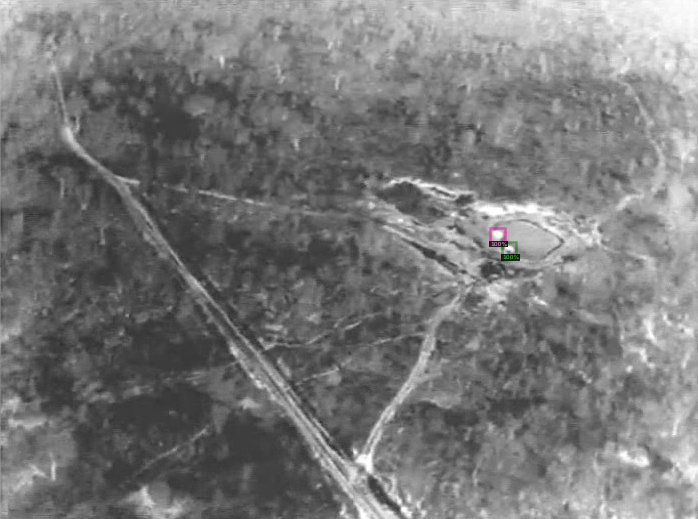

In [20]:
import numpy
import detectron2.utils.visualizer
import google.colab.patches

numpyarray = matplotlib.pyplot.imread(dictionarieslist[2]["file_name"])

numpyarray2 = numpy.stack((numpyarray, numpyarray, numpyarray), axis=2)

config.DATASETS.TEST = ("animalsinfo",)

config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9

config.MODEL.WEIGHTS = "./output/model_final.pth"

predictor = detectron2.engine.DefaultPredictor(config)

output = predictor(numpyarray2)

visualizer = detectron2.utils.visualizer.Visualizer(numpyarray2)

print(output["instances"])

visualizer2 = visualizer.draw_instance_predictions(output["instances"].to("cpu"))

google.colab.patches.cv2_imshow(visualizer2.get_image())

/content/TrainReal/images/0000000067_0000000055/0000000067_0000000055_0000000458.jpg
[{'category_id': 9, 'bbox': [37.0, 134.0, 20.0, 16.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'category_id': 9, 'bbox': [15.0, 101.0, 16.0, 15.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'category_id': 9, 'bbox': [95.0, 77.0, 13.0, 19.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'category_id': 9, 'bbox': [1.0, 76.0, 14.0, 13.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]
Instances(num_instances=4, image_height=512, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 94.7380,  79.3292, 107.6577,  92.1030],
        [ 41.9515, 134.2333,  56.0187, 148.5536],
        [ 18.7136, 103.3761,  30.5671, 115.1585],
        [  3.2564,  75.6666,  16.0975,  88.2048]], device='cuda:0')), scores: tensor([0.9861, 0.9801, 0.9784, 0.9452], device='cuda:0'), pred_classes: tensor([9, 9, 9, 9], device='cuda:0')])


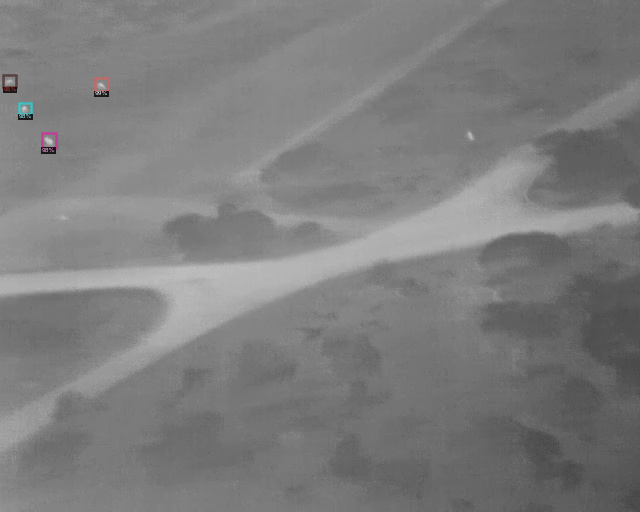

<class 'detectron2.utils.visualizer.VisImage'>


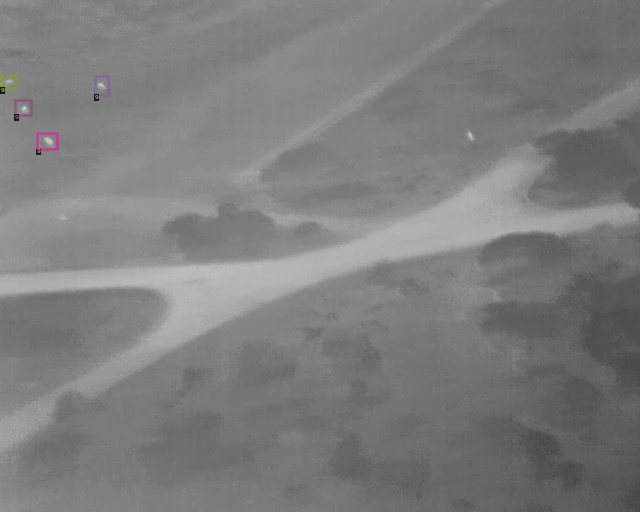

In [21]:
whichimage = 20000

numpyarray = matplotlib.pyplot.imread(dictionarieslist[whichimage]["file_name"])

print(dictionarieslist[whichimage]["file_name"])

print(dictionarieslist[whichimage]["annotations"])

numpyarray2 = numpy.stack((numpyarray, numpyarray, numpyarray), axis=2)

config.DATASETS.TEST = ("animalsinfo",)

config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9

config.MODEL.WEIGHTS = "./output/model_final.pth"

predictor = detectron2.engine.DefaultPredictor(config)

output = predictor(numpyarray2)

visualizer = detectron2.utils.visualizer.Visualizer(numpyarray2)

print(output["instances"])

#print(type(visualizer))

visimage = visualizer.draw_instance_predictions(output["instances"].to("cpu"))

#print(type(visimage))

google.colab.patches.cv2_imshow(visimage.get_image())

visualizer2 = detectron2.utils.visualizer.Visualizer(numpyarray2)

visimage2 = visualizer2.draw_dataset_dict(dictionarieslist[whichimage])

print(type(visimage2))

google.colab.patches.cv2_imshow(visimage2.get_image())

/content/TrainReal/images/0000000010_0000000000/0000000010_0000000000_0000000005.jpg
[{'category_id': 1, 'bbox': [491.0, 228.0, 16.0, 14.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'category_id': 1, 'bbox': [503.0, 244.0, 15.0, 11.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]
Instances(num_instances=2, image_height=519, image_width=698, fields=[pred_boxes: Boxes(tensor([[489.8671, 228.4774, 505.0997, 242.0580],
        [501.7849, 242.2779, 516.6009, 256.0784]], device='cuda:0')), scores: tensor([0.9991, 0.9987], device='cuda:0'), pred_classes: tensor([1, 1], device='cuda:0')])


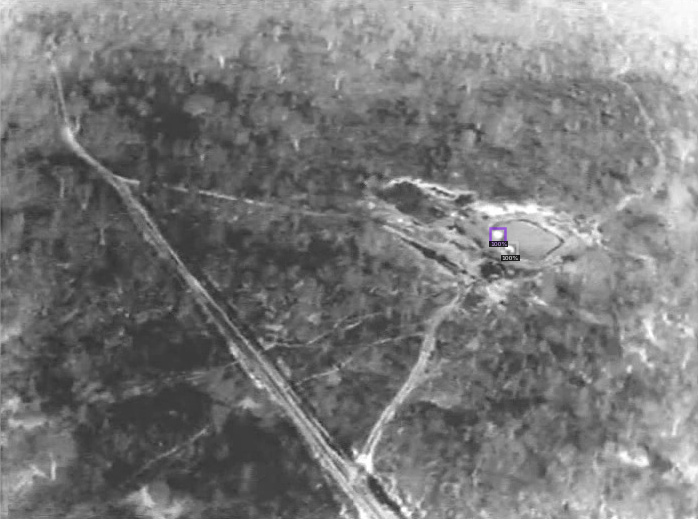

<class 'detectron2.utils.visualizer.VisImage'>


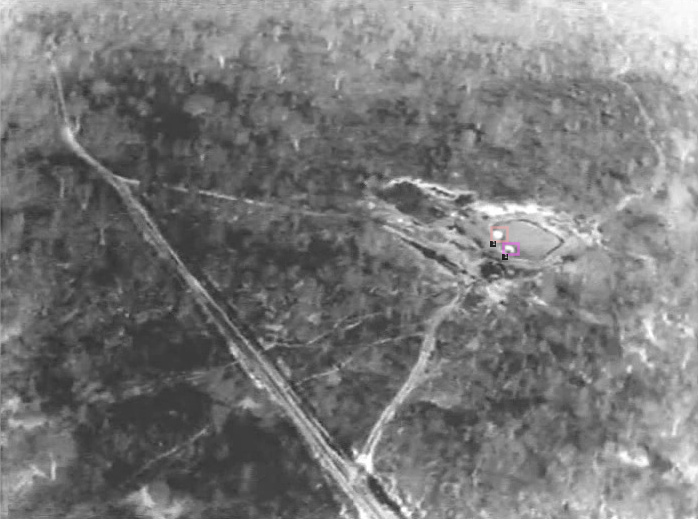

In [22]:
whichimage = 5

numpyarray = matplotlib.pyplot.imread(dictionarieslist[whichimage]["file_name"])

print(dictionarieslist[whichimage]["file_name"])

print(dictionarieslist[whichimage]["annotations"])

numpyarray2 = numpy.stack((numpyarray, numpyarray, numpyarray), axis=2)

config.DATASETS.TEST = ("animalsinfo",)

config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

config.MODEL.WEIGHTS = "./output/model_final.pth"

predictor = detectron2.engine.DefaultPredictor(config)

output = predictor(numpyarray2)

visualizer = detectron2.utils.visualizer.Visualizer(numpyarray2)

print(output["instances"])

#print(type(visualizer))

visimage = visualizer.draw_instance_predictions(output["instances"].to("cpu"))

#print(type(visimage))

google.colab.patches.cv2_imshow(visimage.get_image())

visualizer2 = detectron2.utils.visualizer.Visualizer(numpyarray2)

visimage2 = visualizer2.draw_dataset_dict(dictionarieslist[whichimage])

print(type(visimage2))

google.colab.patches.cv2_imshow(visimage2.get_image())

In [23]:
def gettestdata():

  return testdictionarieslist

In [24]:
#detectron2.data.DatasetCatalog.remove("testinfo")

detectron2.data.DatasetCatalog.register("testinfo", gettestdata)

#detectron2.data.MetadataCatalog.remove("testinfo")

detectron2.data.MetadataCatalog.get("testinfo").set(thing_classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

Metadata(name='testinfo', thing_classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [25]:
evaluator = detectron2.evaluation.COCOEvaluator("testinfo", config, False, output_dir="./output/")

[07/21 18:08:11 d2.evaluation.coco_evaluation]: 'testinfo' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/21 18:08:11 d2.data.datasets.coco]: Converting annotations of dataset 'testinfo' to COCO format ...)
[07/21 18:08:11 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/21 18:08:11 d2.data.datasets.coco]: Conversion finished, #images: 1000, #annotations: 2195
[07/21 18:08:11 d2.data.datasets.coco]: Caching COCO format annotations at './output/testinfo_coco_format.json' ...


In [26]:
evaluationloader = detectron2.data.build_detection_test_loader(config, "testinfo")

[07/21 18:08:19 d2.data.build]: Distribution of instances among all 10 categories:
|  category  | #instances   | category   | #instances   | category   | #instances   |
|:----------:|:-------------|:-----------|:-------------|:-----------|:-------------|
|     0      | 281          | 1          | 1091         | 2          | 12           |
|     3      | 283          | 4          | 0            | 5          | 0            |
|     6      | 0            | 7          | 0            | 8          | 0            |
|     9      | 528          |            |              |            |              |
|   total    | 2195         |            |              |            |              |
[07/21 18:08:19 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[07/21 18:08:19 d2.data.common]: Serialized dataset takes 0.34 MiB
[07/21 18:08:19 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, samp

In [27]:
print(detectron2.evaluation.inference_on_dataset(trainer.model, evaluationloader, evaluator))

[07/21 18:08:25 d2.evaluation.evaluator]: Start inference on 1000 images
[07/21 18:08:26 d2.evaluation.evaluator]: Inference done 11/1000. 0.0598 s / img. ETA=0:01:00
[07/21 18:08:31 d2.evaluation.evaluator]: Inference done 92/1000. 0.0606 s / img. ETA=0:00:56
[07/21 18:08:36 d2.evaluation.evaluator]: Inference done 174/1000. 0.0602 s / img. ETA=0:00:50
[07/21 18:08:41 d2.evaluation.evaluator]: Inference done 255/1000. 0.0603 s / img. ETA=0:00:45
[07/21 18:08:46 d2.evaluation.evaluator]: Inference done 336/1000. 0.0604 s / img. ETA=0:00:41
[07/21 18:08:51 d2.evaluation.evaluator]: Inference done 418/1000. 0.0603 s / img. ETA=0:00:35
[07/21 18:08:56 d2.evaluation.evaluator]: Inference done 499/1000. 0.0603 s / img. ETA=0:00:30
[07/21 18:09:01 d2.evaluation.evaluator]: Inference done 581/1000. 0.0603 s / img. ETA=0:00:25
[07/21 18:09:06 d2.evaluation.evaluator]: Inference done 663/1000. 0.0603 s / img. ETA=0:00:20
[07/21 18:09:11 d2.evaluation.evaluator]: Inference done 745/1000. 0.0603 